# Bay Wheels Age Trends

## Background
The dataset I chose for this reseach proposal was taken from the [Bay Wheels](https://www.lyft.com/bikes/bay-wheels/system-data) system data, which was provided under the [Bay Wheels License Agreement](https://baywheels-assets.s3.amazonaws.com/data-license-agreement.html). [Bay Wheels](https://www.lyft.com/bikes/bay-wheels) is a bike share service that has recently been acquired by Lyft. Currently 2600 bikes are in opperation from 262 stations from San Francisco to San Jose and the East Bay. Lyft expects to increase the number of bikes to 7000 and the number of stations to 540.

The research proposal laid out below will assume this bike share system does not exist and that I am designing it to address a particular experiment.

# Research Proposal

I would like to study how bike use varies between age groups and genders.

## Hypothesis
**There is no difference in age between genders for people who use bikes in the Bay Area.**

## Rollout Plan
In order to address this hypothesis, I need three main items:
1. Bikes.
2. Users.
3. A database of user data.

### Bikes
I would distribute bike stations in several cities around the Bay Area. This would ensure a random sample of users in the Bay Area. Only restricting stations to a few cities would bias this study towards those cities.

### Users
This entails creating accounts where I can gather user data which can be used for this study. I would create a web application as well as a phone app where users could sign up. They would be required to enter their birth year and gender. They would use their user account to check out a bike. This way I could keep track of what type of users are bikers.

### Database
When a user checks out a bike, their information would be sent to a database. The database would keep track of: user ID, member birth year, member gender.

## One Month In
After enacting this study for one month, I can begin to address my hypothesis. The data has been stored in a csv file. Let's load it and see what we have.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from statistics import mode

%matplotlib inline

### Load the data
Load data for May, 2018 into a Pandas `DataFrame`.

In [2]:
df = pd.read_csv('./data/201805-fordgobike-tripdata.csv', parse_dates=True, infer_datetime_format=True)

## Exploratory Data Analysis
Let's begin by exploring what data we acquired and how it can be used to address the hypothesis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179125 entries, 0 to 179124
Data columns (total 16 columns):
duration_sec               179125 non-null int64
start_time                 179125 non-null object
end_time                   179125 non-null object
start_station_id           179125 non-null int64
start_station_name         179125 non-null object
start_station_latitude     179125 non-null float64
start_station_longitude    179125 non-null float64
end_station_id             179125 non-null int64
end_station_name           179125 non-null object
end_station_latitude       179125 non-null float64
end_station_longitude      179125 non-null float64
bike_id                    179125 non-null int64
user_type                  179125 non-null object
member_birth_year          167376 non-null float64
member_gender              167413 non-null object
bike_share_for_all_trip    179125 non-null object
dtypes: float64(5), int64(4), object(7)
memory usage: 21.9+ MB


Here we see that we acquired data for 179124 rides.

Some riders failed to record their birth year and gender.

In [4]:
missing_birth_year_count = pd.isna(df['member_birth_year']).sum()
missing_gender_count = pd.isna(df['member_gender']).sum()
print(f'Fraction of missing birth years = {missing_birth_year_count / len(df):.3f}')
print(f'Fraction of missing genders = {missing_gender_count / len(df):.3f}')

Fraction of missing birth years = 0.066
Fraction of missing genders = 0.065


The _start\__time_ and _end\__time_ columns are not in date-time format. We will need to convert these to date-time format so that we can compute rider ages.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_sec,179125.0,854.904346,2396.553157,61.000000,342.000000,548.000000,870.000000,86208.000000
start_station_id,179125.0,112.994546,94.929468,3.000000,30.000000,81.000000,178.000000,350.000000
start_station_latitude,179125.0,37.768174,0.098525,37.312854,37.771058,37.781074,37.795392,37.880222
start_station_longitude,179125.0,-122.354925,0.117421,-122.444293,-122.411738,-122.398525,-122.299371,-121.874119
end_station_id,179125.0,111.489932,94.612239,3.000000,30.000000,81.000000,178.000000,350.000000
end_station_latitude,179125.0,37.768283,0.098425,37.312854,37.771058,37.781074,37.795392,37.880222
end_station_longitude,179125.0,-122.354431,0.116934,-122.444293,-122.411647,-122.398436,-122.299371,-121.874119
bike_id,179125.0,2413.880860,1260.417897,11.000000,1340.000000,2577.000000,3642.000000,4231.000000
member_birth_year,167376.0,1982.186425,10.320561,1889.000000,1977.000000,1985.000000,1990.000000,2000.000000


Here we see non-sensical birth years (1889). This will be addressed when I compute member ages.

## Data Cleaning and Manipulation
Now it is time to clean the data so that I can extract meaningful results. I define an empyt dictionary and function which will be used for data cleaning and data manipulation. For each step in this process I will define separate functions. The `cleaning_dict` dictionary will store information about what function to use at that step and whether to turn that cleaning/manipulation step on or off. The `clean_dataset()` function will perform the data cleaning/manipulation.

In [6]:
cleaning_dict = {}

In [7]:
def clean_dataset(df):
    for key, value in cleaning_dict.items():
        if value['flag']:
            df = value['method'](df, *value['args'], **value['kwargs'])
    return df

### Missing birth years and genders

Remove rows with missing birth year and gender. Since there is no way to infer these features, removing them is fine.

In [8]:
def clear_missing_year_gender(df, *args, **kwargs):
    df_out = df.loc[(pd.notna(df['member_birth_year']) & pd.notna(df['member_gender'])), :].copy()
    df_out.index = np.arange(len(df_out))
    return df_out

In [9]:
cleaning_dict['missing_year_gender'] = {
    'flag': False,
    'method': clear_missing_year_gender,
    'args': [],
    'kwargs': {}
}

In [10]:
cleaning_dict['missing_year_gender']['flag'] = True

In [11]:
df_clean = clean_dataset(df)

### Genders
Let's see how many genders are included in this dataset.

In [12]:
f"The member genders are: {df_clean['member_gender'].unique().tolist()}"

"The member genders are: ['Male', 'Female', 'Other']"

For this analysis, I will only include male and female genders.

In [13]:
def create_male_female(df, *args, **kwargs):
    df_out = df[df['member_gender'] != 'Other'].copy()
    df_out.index = np.arange(len(df_out))
    return df_out

In [14]:
cleaning_dict['male_female'] = {
    'flag': False,
    'method': create_male_female,
    'args': [],
    'kwargs': {}
}

In [15]:
cleaning_dict['male_female']['flag'] = True

In [16]:
df_clean = clean_dataset(df)

In [17]:
f"Genders in analysis: {df_clean['member_gender'].unique().tolist()}"

"Genders in analysis: ['Male', 'Female']"

### Compute ages
The ages will be computed as the difference between the year the ride took place and the member's birth year. The _start\__time_ and _end\__time_ columns will be converted to date-time format to make it easier to extract the year of the ride.

In [18]:
def compute_ages(df):
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    df['start_year'] = df['start_time'].apply(lambda x: x.year)
    df['end_year'] = df['end_time'].apply(lambda x: x.year)
    df['member_age'] = df['start_year'] - df['member_birth_year']
    return df

In [19]:
cleaning_dict['compute_ages'] = {
    'flag': False,
    'method': compute_ages,
    'args': [],
    'kwargs': {}
}

In [20]:
cleaning_dict['compute_ages']['flag'] = True

In [21]:
df_clean = clean_dataset(df)

Now that we have member ages, we can view their distribution using a histogram.

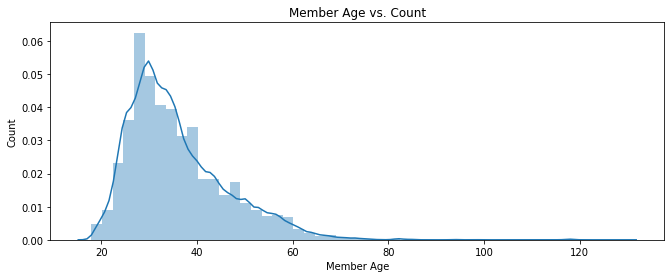

In [22]:
fig, ax = plt.subplots(figsize=(11, 4))
sns.distplot(df_clean['member_age'].values, 
             ax=ax)
plt.title('Member Age vs. Count')
plt.xlabel('Member Age')
plt.ylabel('Count')
plt.show()

Notice that most ages are around 30 and that there is a long tail extending past age 80. This is a highly right skewed distribution, which will make accurately computing the t-statistic and p-value difficult. I will address this by converting ages into log(ages).

In [23]:
def compute_log_age(df):
    df['log_age'] = np.log(df['member_age'].values)
    return df

In [24]:
cleaning_dict['compute_log_age'] = {
    'flag': False,
    'method': compute_log_age,
    'args': [],
    'kwargs': {}
}

In [25]:
cleaning_dict['compute_log_age']['flag'] = True

In [26]:
df_clean = clean_dataset(df)

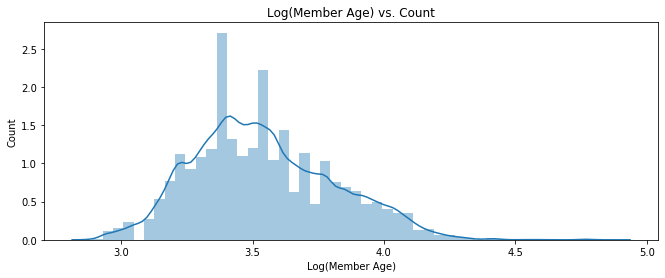

In [27]:
fig, ax = plt.subplots(figsize=(11, 4))
sns.distplot(df_clean['log_age'].values, 
             ax=ax)
plt.title('Log(Member Age) vs. Count')
plt.xlabel('Log(Member Age)')
plt.ylabel('Count')
plt.show()

The distribution looks more normal, but there still is a long tail to the right. Let's re-normalize outlier points to the median value of the distribution.

### Age Outliers
Normalize the log(member age) values to the median value of the distribution.

In [28]:
def normalize_outliers(df, *args, **kwargs):
    median_value = df[args[0]].median()
    quantiles = df[args[0]].quantile([0.25, 0.75]).values
    IQR = quantiles[1] - quantiles[0]
    max_thresh = quantiles[1] + kwargs['thresh']*IQR
    min_thresh = quantiles[0] - kwargs['thresh']*IQR
    df[args[0]] = df[args[0]].apply(lambda x: x if (x < max_thresh and x > min_thresh) else median_value)
    return df

In [29]:
cleaning_dict['normalize_log_age'] = {
    'flag': False,
    'method': normalize_outliers,
    'args': ['log_age'],
    'kwargs': {'thresh': 1.5}
}

In [30]:
cleaning_dict['normalize_log_age']['flag'] = True

In [31]:
df_clean = clean_dataset(df)

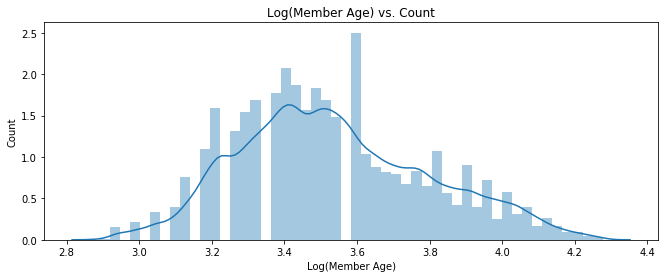

In [32]:
fig, ax = plt.subplots(figsize=(11, 4))
sns.distplot(df_clean['log_age'].values, 
             ax=ax)
plt.title('Log(Member Age) vs. Count')
plt.xlabel('Log(Member Age)')
plt.ylabel('Count')
plt.show()

Now the distibution looks more normal. At this point, we can begin to address our hypothesis. I will divide the distribution into two groups, male and female, and compare how similar each distribution is by using the t-statistic and p-value.

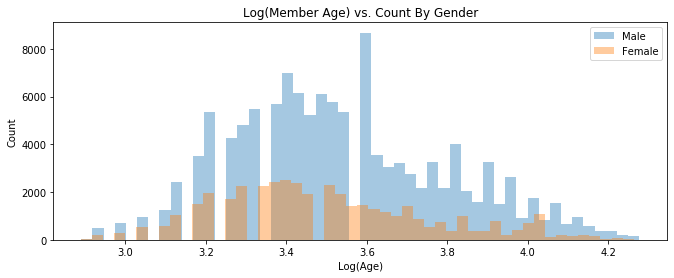

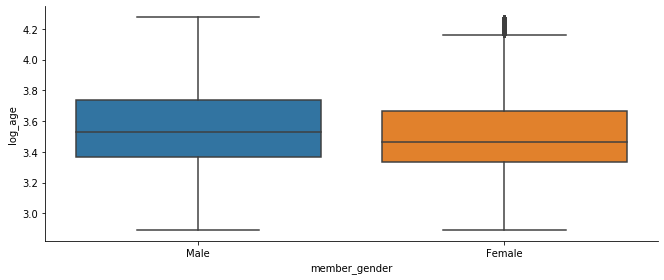

In [33]:
fig, ax = plt.subplots(figsize=(11, 4))
for gender in df_clean['member_gender'].unique():
    sns.distplot(df_clean.loc[df_clean['member_gender'] == gender, 'log_age'], ax=ax, kde=False)
plt.legend(df_clean['member_gender'].unique().tolist())
plt.title('Log(Member Age) vs. Count By Gender')
plt.xlabel('Log(Age)')
plt.ylabel('Count')
plt.show()

sns.catplot(x='member_gender', y='log_age', data=df_clean, height=4, aspect=14/6, kind='box')
plt.show()

In [34]:
mean_age = df_clean['member_age'].mean()
male_mean_age = df_clean.loc[df_clean['member_gender'] == 'Male', 'member_age'].mean()
female_mean_age = df_clean.loc[df_clean['member_gender'] == 'Female', 'member_age'].mean()
male_log_ages = df_clean.loc[df_clean['member_gender'] == 'Male', 'log_age'].values
female_log_ages = df_clean.loc[df_clean['member_gender'] == 'Female', 'log_age'].values
tstat, pval = stats.ttest_ind(male_log_ages, female_log_ages)
print(f'Num males = {len(male_log_ages)}, Num females = {len(female_log_ages)}')
print(f'Proportion (male/female): {len(male_log_ages) / len(female_log_ages):0.3f}')
print(f'Mean age: {mean_age:0.3f}')
print(f'Log(Member Age): t-statistic = {tstat}, p-value = {pval}')
print(f'Mean log(age): {np.mean(male_log_ages):0.3f} [male], {np.mean(female_log_ages):0.3f} [female]')
print(f'Mean Age: {male_mean_age:0.3f} [male], {female_mean_age:0.3f} [female]')

Num males = 122783, Num females = 41974
Proportion (male/female): 2.925
Mean age: 35.802
Log(Member Age): t-statistic = 28.12016521690779, p-value = 1.4333292022873801e-173
Mean log(age): 3.548 [male], 3.506 [female]
Mean Age: 36.201 [male], 34.633 [female]


The large t-statistic and extremely small p-value shows that there is a big difference between the male and female distributions. The average age is 35.8. On average, males are two years older than females. Another thing to notice is there are almost three times as many males as females who use Bay Wheels.

### Age groups
Let's further this analysis by breaking down the ages into groups and comparing each of these smaller groups.

In [35]:
def create_log_age_groups(df, step=0.2):
    min_log_age = df['log_age'].min()
    max_log_age = df['log_age'].max()
    lower = (min_log_age*10 - min_log_age*10 % 2) / 10
    upper = (max_log_age*10 + max_log_age*10 % 2) / 10
    edges = np.arange(lower, upper+step, step)
    labels = [f'{x:0.1f}-{y:0.1f}' for x, y in zip(edges[:-1], edges[1:])]
    bins = edges
    df['log_age_group'] = pd.cut(df['log_age'].values, bins, labels=labels)
    df['log_age_group'] = df['log_age_group'].astype('str')
    return df

In [36]:
cleaning_dict['log_age_groups'] = {
    'flag': False,
    'method': create_log_age_groups,
    'args': [],
    'kwargs': {'step': 0.4}
}

In [37]:
cleaning_dict['log_age_groups']['flag'] = True

In [38]:
df_clean = clean_dataset(df)

In [39]:
print(f"The log(age) groups are: {np.unique(df_clean['log_age_group'].values)}")

The log(age) groups are: ['2.8-3.2' '3.2-3.6' '3.6-4.0' '4.0-4.4']


Ranges: log(age) [2.8-3.2], age [24.5-16.4]
   num males = 9381, num females = 4141
   proportion (male/female): 2.265
   mean log(age): 3.114 [male], 3.112 [female]
   mean age: 22.576 [male], 22.519 [female]
   pvalue = 0.05120044780659197, t-statistic = 1.9499690574895796


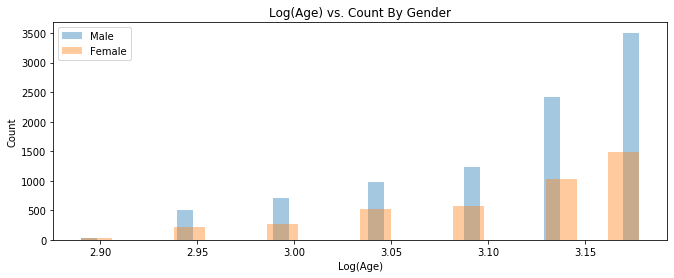

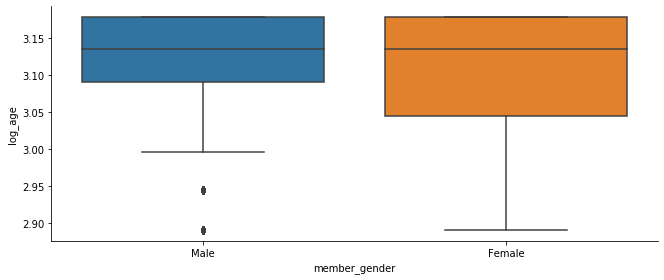

Ranges: log(age) [3.2-3.6], age [36.6-24.5]
   num males = 66464, num females = 24492
   proportion (male/female): 2.714
   mean log(age): 3.416 [male], 3.404 [female]
   mean age: 31.008 [male], 30.453 [female]
   pvalue = 5.222235028947346e-47, t-statistic = 14.407613198011544


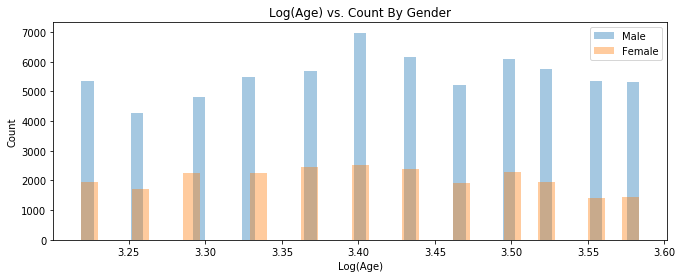

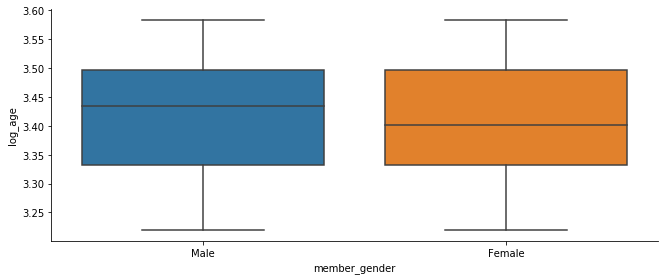

Ranges: log(age) [3.6-4.0], age [54.6-36.6]
   num males = 39575, num females = 10839
   proportion (male/female): 3.651
   mean log(age): 3.772 [male], 3.759 [female]
   mean age: 43.748 [male], 43.200 [female]
   pvalue = 4.5904985912566764e-26, t-statistic = 10.565404513902578


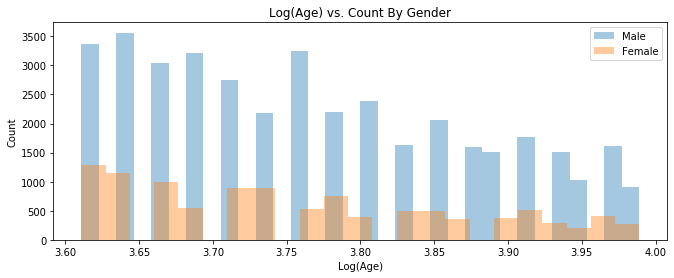

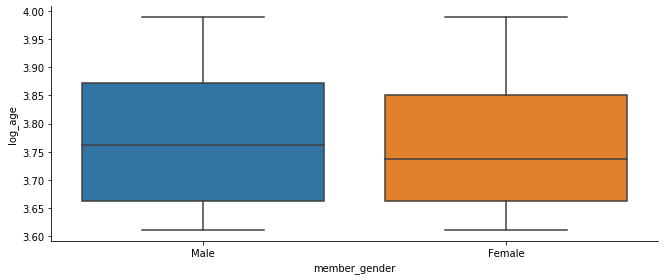

Ranges: log(age) [4.0-4.4], age [81.5-54.6]
   num males = 7363, num females = 2502
   proportion (male/female): 2.943
   mean log(age): 4.090 [male], 4.067 [female]
   mean age: 59.877 [male], 58.483 [female]
   pvalue = 6.927719834895462e-52, t-statistic = 15.244945493413116


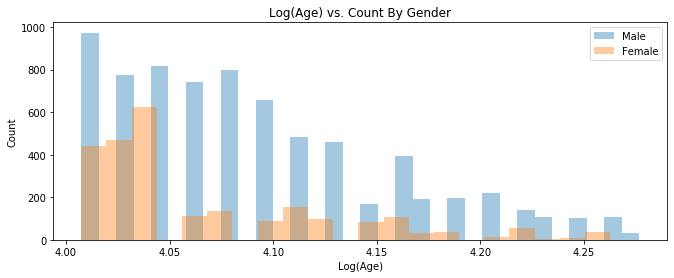

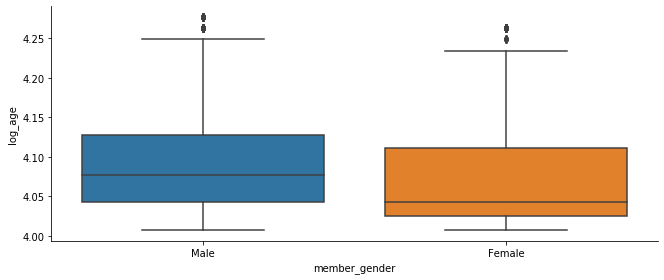

In [40]:
for age_group in np.unique(df_clean['log_age_group'].values):
    sub_df = df_clean.loc[df_clean['log_age_group'] == age_group, :].copy()
    min_age = np.e**float(age_group.split('-')[0])
    max_age = np.e**float(age_group.split('-')[1])
    mean_male_age = sub_df.loc[sub_df['member_gender'] == 'Male', 'member_age'].mean()
    mean_female_age = sub_df.loc[sub_df['member_gender'] == 'Female', 'member_age'].mean()
    male_log_ages = sub_df.loc[sub_df['member_gender'] == 'Male', 'log_age'].values
    female_log_ages = sub_df.loc[sub_df['member_gender'] == 'Female', 'log_age'].values
    tstat, pval = stats.ttest_ind(male_log_ages, female_log_ages)
    print(f'Ranges: log(age) [{age_group}], age [{max_age:0.1f}-{min_age:0.1f}]')
    print(f'   num males = {len(male_log_ages)}, num females = {len(female_log_ages)}')
    print(f'   proportion (male/female): {len(male_log_ages) / len(female_log_ages):0.3f}')
    print(f'   mean log(age): {np.mean(male_log_ages):0.3f} [male], {np.mean(female_log_ages):0.3f} [female]')
    print(f'   mean age: {mean_male_age:0.3f} [male], {mean_female_age:0.3f} [female]')
    print(f'   pvalue = {pval}, t-statistic = {tstat}')
        
    fig, ax = plt.subplots(figsize=(11, 4))
    for gender in sub_df['member_gender'].unique():
        sns.distplot(sub_df.loc[sub_df['member_gender'] == gender, 'log_age'], ax=ax, kde=False)
    plt.legend(sub_df['member_gender'].unique().tolist())
    plt.title('Log(Age) vs. Count By Gender')
    plt.xlabel('Log(Age)')
    plt.ylabel('Count')
    plt.show()
    
    sns.catplot(x='member_gender', y='log_age', data=sub_df, height=4, aspect=14/6, kind='box')
    plt.show()

Except for the youngest group, on average males are older than females for each group. The large p-value in the youngest group indicates that the male and female distributions do not differ.

## Conclusions
In this study I wished to explore whether there was a difference in ages between males and females who used bikes in the Bay Area. I concluded that on average males are younger than females. Even when broken down into age groups, this trend was also see. The only exception was the youngest group, which did not show any difference in mean ages.

One unexpected result was that there are almost three times as many males who used the bike share program than females. I would propose creating an advertising campaign to encourage more female riders.

## Further Analysis
### Longer Study
This experiment was only performed on one-month's acquisition of data. Further insight into age/gender trends can be accomplished by increasing the study to a year.

### Ride Duration
Another hypothesis that could be addressed with these data is how ride duration varies between genders.